# **EXTIMATING THE AGE OF PEOPLE FROM VOCAL RECORDINGS**
BELLO RENATO and CHIODO MARTINA

In [1]:
# importing the modules we will nedd --> TOGLIERE QUELLE SUPERFLUE!!!!!!!!!!
import csv
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

## **EXTRACTION OF SIGNIFICATIVE FEATURES FROM THE RECORDINGS**

In [ ]:
# For convenience, we decided to write new csv containing all the features contained in the given dataset plus the features extracted by the audio recordings 
from modules.extract_feature import new_csv_with_audio_extracted_features

num_segm = 20
new_csv_with_audio_extracted_features(num_segmentation=num_segm)

## **DATA EXPLORATION**

In [2]:
# Loading the datasets from the previously csv created
num_segm = 20
data_dev = pd.read_csv(f'datasets/development_features_{num_segm}.csv')
data_eval = pd.read_csv(f'datasets/evaluation_features_{num_segm}.csv')
df = pd.read_csv(f'datasets/development.csv')

# We can perform some data exploration, for convenience we are going to look only at the ones given in the initial datasets
labels = list(df.columns.values)
labels.remove('ethnicity')
labels.remove('path')
labels.remove('Id')
labels.remove('gender')
labels.append('gender_male')
labels.append('gender_female')


In [3]:
# Do we have any missin values?
null_values_dev = data_dev.isnull().sum()
null_values_eval = data_eval.isnull().sum()
print("Count total NaN at each column in data_dev : \n", null_values_dev) 
print("Count total NaN at each column in data_eval : \n", null_values_eval) 

Count total NaN at each column in data_dev : 
 Id               0
sampling_rate    0
age              0
mean_pitch       0
max_pitch        0
                ..
mfcc_6           0
mfcc_7           0
mfcc_8           0
mfcc_9           0
mfcc_10          0
Length: 235, dtype: int64
Count total NaN at each column in data_eval : 
 Id               0
sampling_rate    0
mean_pitch       0
max_pitch        0
min_pitch        0
                ..
mfcc_6           0
mfcc_7           0
mfcc_8           0
mfcc_9           0
mfcc_10          0
Length: 234, dtype: int64


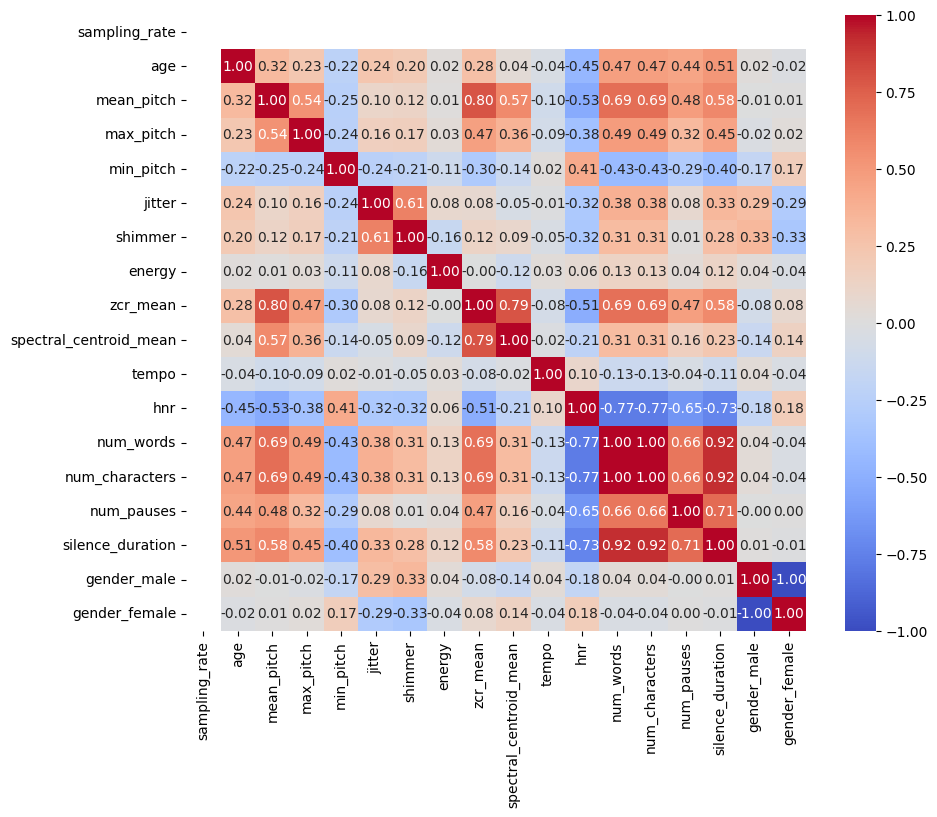

In [4]:
# We can look at the correlation between features
correlation_matrix = data_dev[labels].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

From this correlation graph, we can see that num_words and num_characters have the maximum value that the correlation can assume. Thus we are keeping just one of these features to avoid rendundance.

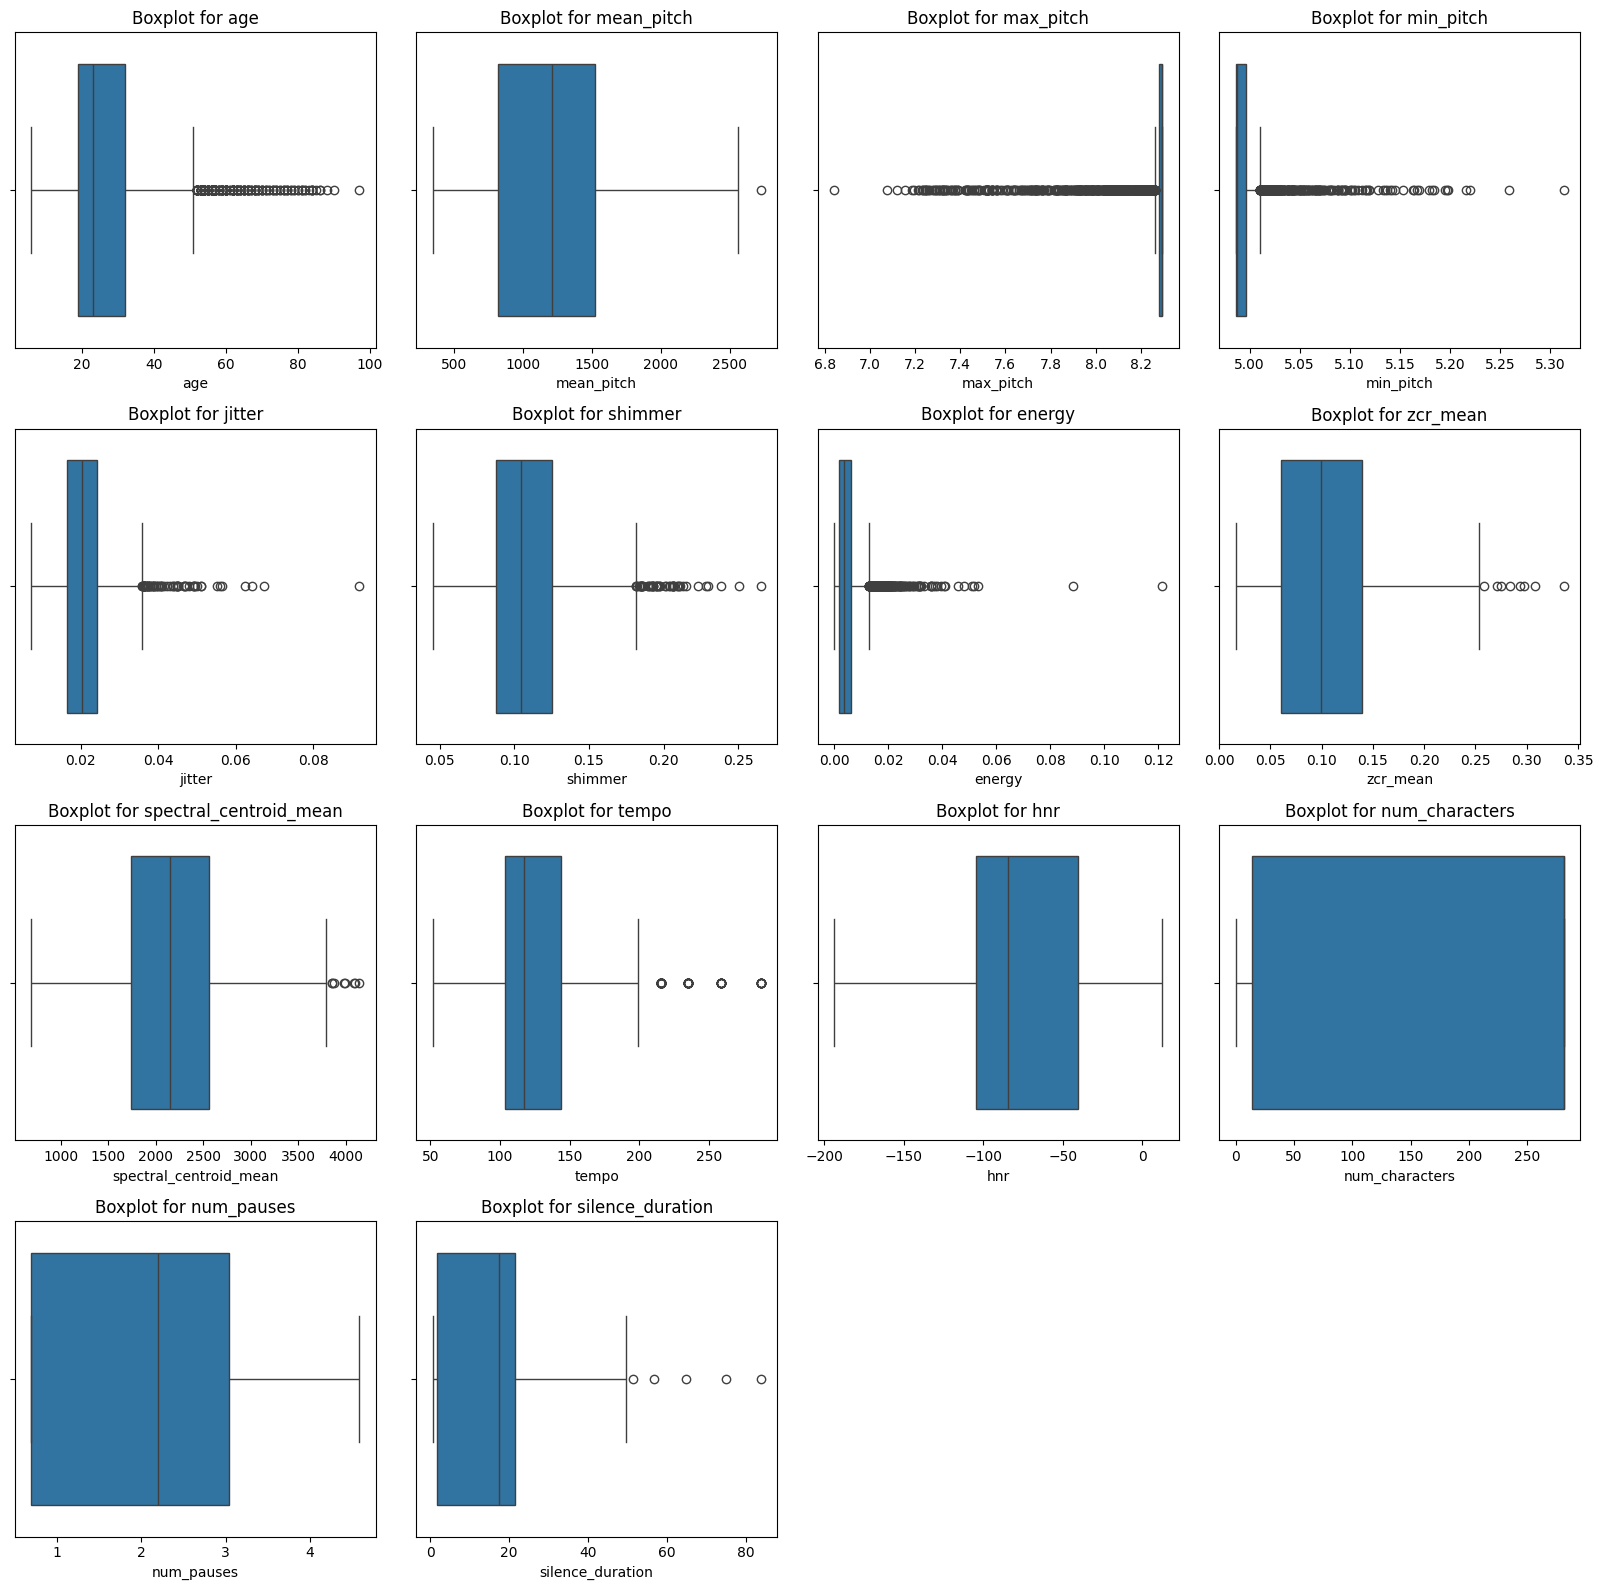

In [5]:
Xdata_dev = data_dev.drop(columns=['path', 'Id', 'age', 'num_words', 'gender_female'])
ydata_dev = data_dev['age']
Xdata_eval = data_eval.drop(columns=['path', 'num_words', 'gender_female'])

# Some boxplots to look at the distribution of the numerical features, for some features we are going to apply a log transformation
# Boxplots can be helpful to detect outliers
copy_dev = Xdata_dev.copy()
copy_eval = Xdata_eval.copy()

numerical_columns = labels.copy()
numerical_columns.remove('num_words')
numerical_columns.remove('gender_female')
numerical_columns.remove('gender_male')
numerical_columns.remove('sampling_rate')


for col in ['num_pauses',  'energy', 'jitter', 'min_pitch', 'max_pitch']:
    copy_dev[col] = np.log1p(copy_dev[col])
    copy_eval[col] = np.log1p(copy_eval[col])
  

# Displaying 4 boxplots for row
cols_per_row = 4
rows = (len(numerical_columns) + cols_per_row - 1) // cols_per_row
# Create a grid of boxplots using seaborn
fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    if column == 'age':
        sns.boxplot(x=ydata_dev, ax=axes[i])
    else:
        sns.boxplot(x=copy_dev[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


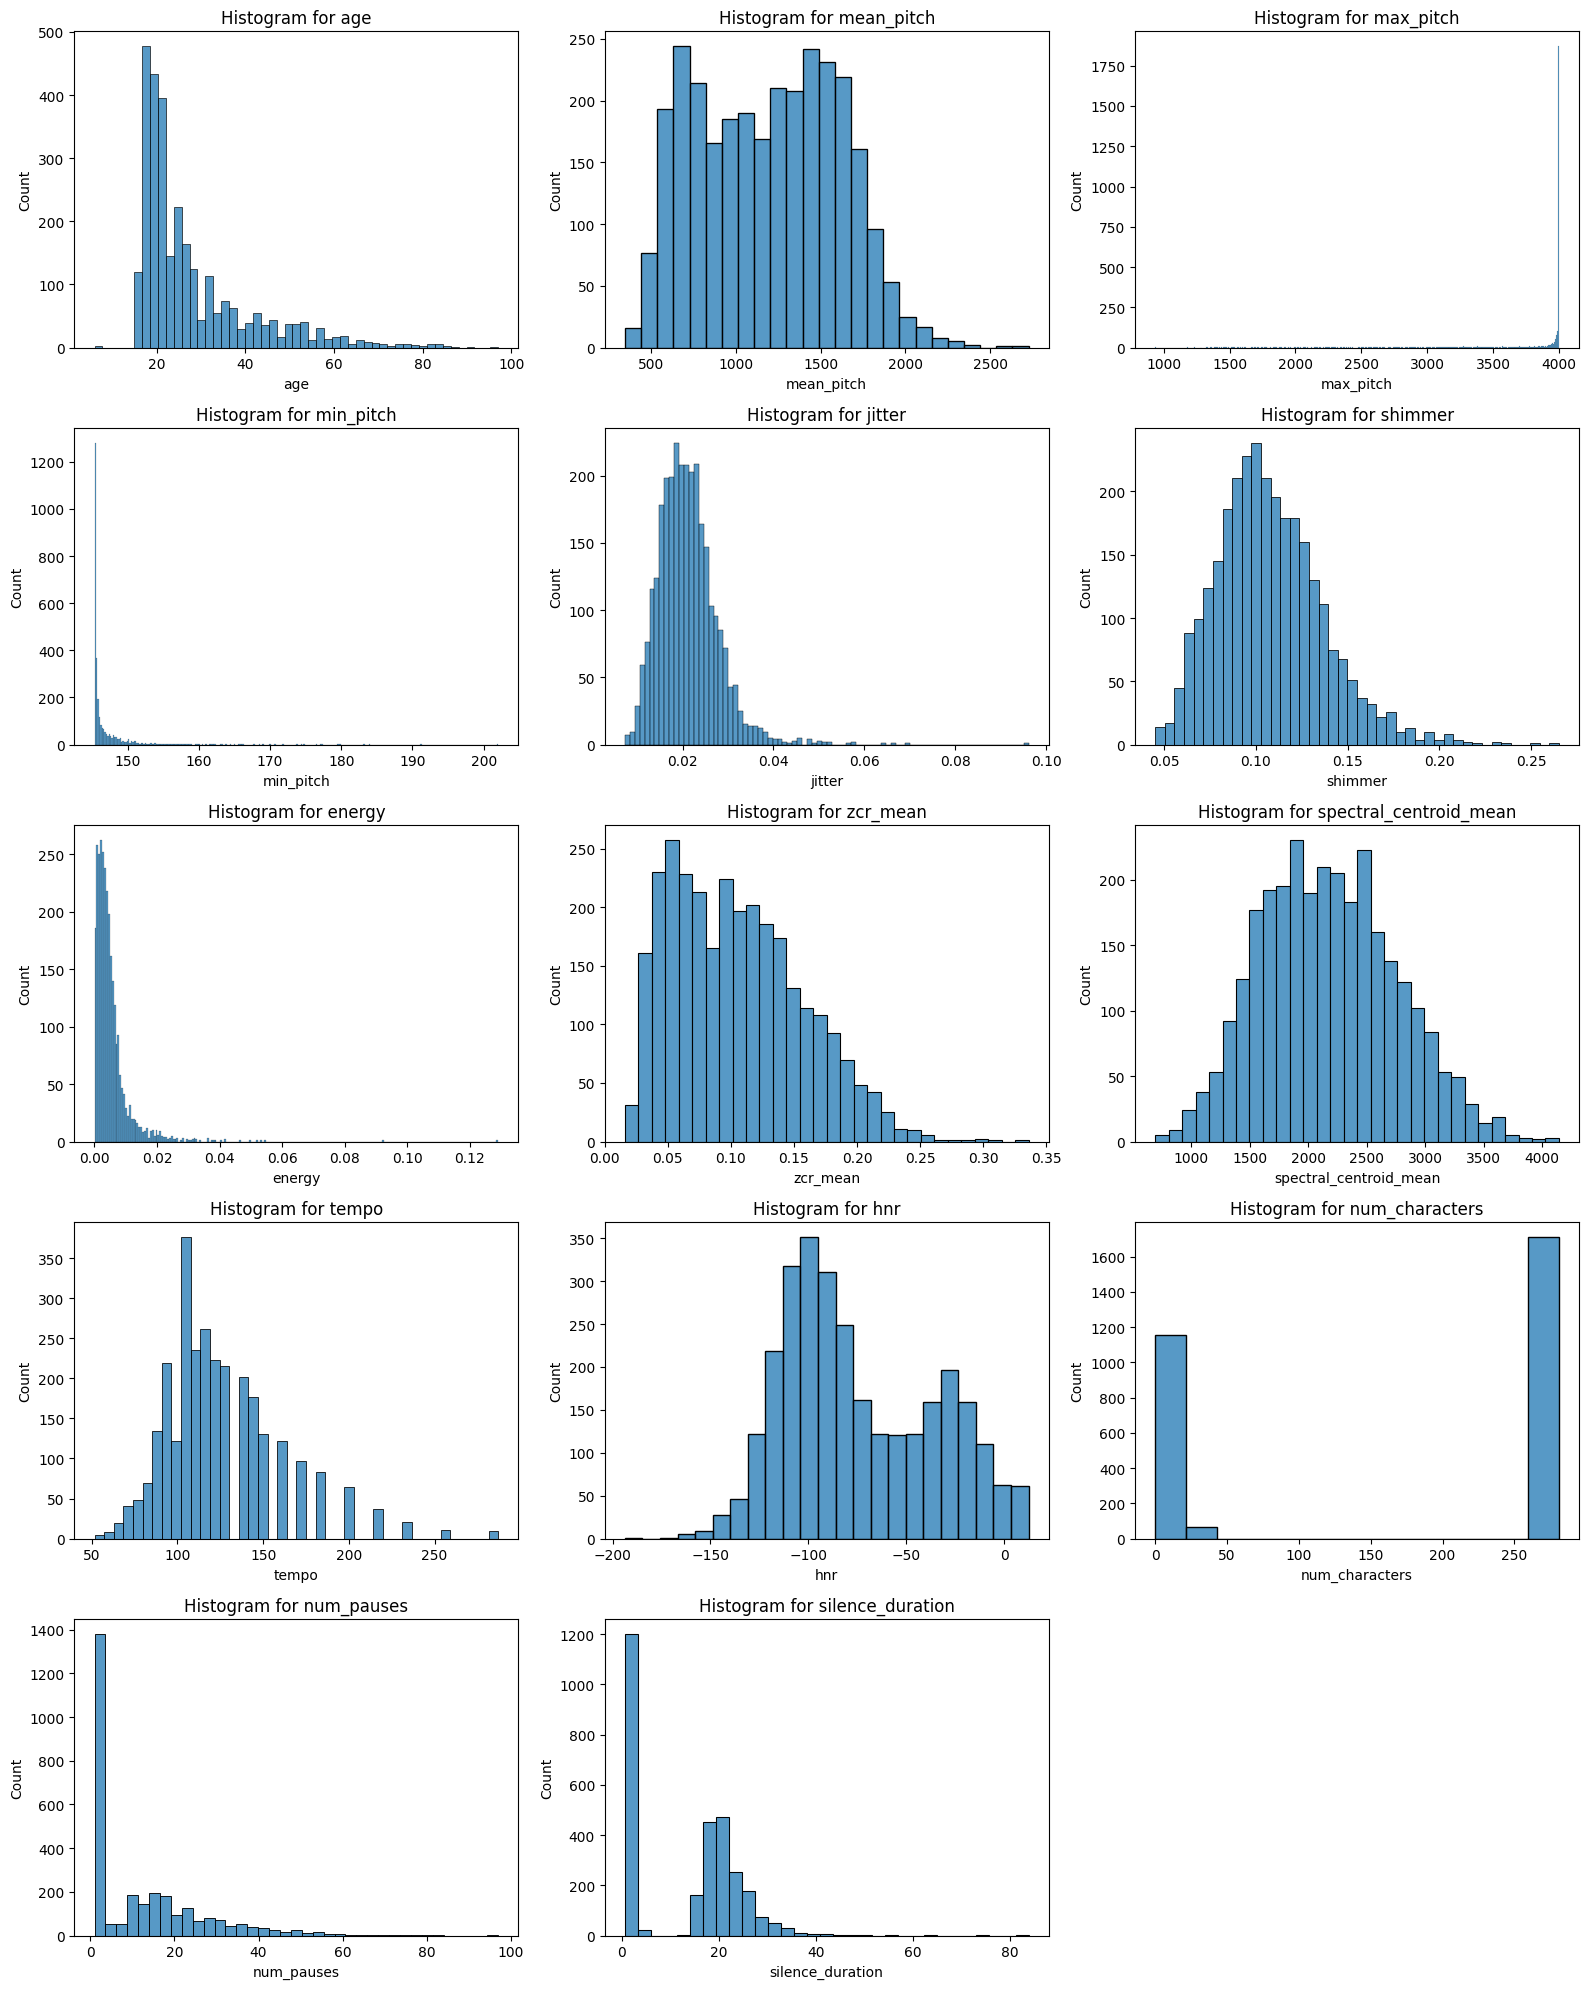

In [6]:
# Displaying 4 boxplots for row
cols_per_row = 3
rows = (len(numerical_columns) + cols_per_row - 1) // cols_per_row
# Create a grid of boxplots using seaborn
fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    if column == 'age':
        sns.histplot(x=ydata_dev, ax=axes[i])
    else:
        sns.histplot(x=Xdata_dev[column], ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)

for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## **PREPROCESSING**

In [7]:
# Dividing the dataset into development and validation
X_train, X_validation, y_train, y_validation = train_test_split(copy_dev, ydata_dev, test_size=0.2, random_state=42)


# We decided to standardize the datasets using a standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

## **MODELS**

In this section we will compare the performances of two regressors to decide the one which performs better. 
Before training the regressor, we are going to apply an RFE in order to extract a subset of features that better explains the data in order to avoid overfitting due to the usage of many features and to avoid an excessive computational cost while fitting the regression.
For both regressor we are going to perform a GridSearch to find the best hyper-parameters of the regressor.
In order to evaluate the performances of the regressors we are going to use the root mean squared error (RMSE).

#### **RIDGE REGRESSOR**

TRAINING THE RIDGE REGRESSOR ... 

The best score is obtained for numfeat = 50 and its value is 9.526367154604252 


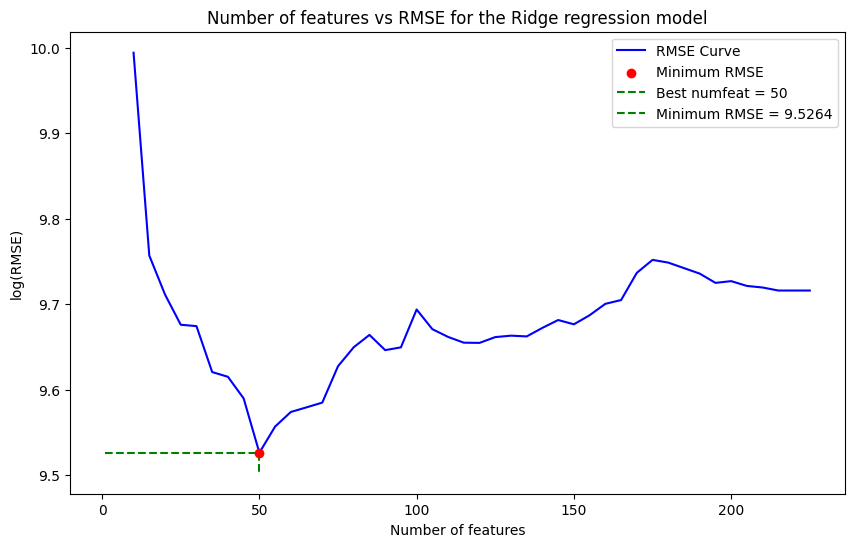

In [8]:
model = Ridge()
print('TRAINING THE RIDGE REGRESSOR ... \n')

best_numfeat = 95
best_score = 50
scores = []


# First we define the features which best describe the dataset
for numfeat in range(10, len(copy_dev.columns), 5):
    rfe = RFE(model, n_features_to_select= numfeat)  
    rfe.fit(X_train, y_train)
    
    X_train_selected_forest = rfe.transform(X_train)
    X_test_selected_forest = rfe.transform(X_validation)

    # Fit and evaluating the model
    model.fit(X_train_selected_forest, y_train)
    score = root_mean_squared_error(y_validation, model.predict(X_test_selected_forest))
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_numfeat = numfeat
        
print(f'The best score is obtained for numfeat = {best_numfeat} and its value is {best_score} ')  


# PLOT NUM_FEAT - RMSE
plt.figure(figsize=(10, 6))
xseq = range(10, len(copy_dev.columns), 5)
plt.plot(xseq, scores, label='RMSE Curve', color='blue')
plt.scatter([best_numfeat], [best_score], color='red', zorder=5, label='Minimum RMSE')
plt.plot([best_numfeat, best_numfeat], [best_score, plt.ylim()[0]], color='green', linestyle='--', label=f'Best numfeat = {best_numfeat}')
plt.plot([1, best_numfeat], [best_score, best_score], color='green', linestyle='--', label=f'Minimum RMSE = {best_score:.4f}')
plt.xlabel('Number of features')
plt.ylabel('log(RMSE)')
plt.title('Number of features vs RMSE for the Ridge regression model')
plt.legend()
plt.show()


In [16]:
# Computing the best mask
rfe = RFE(model, n_features_to_select= best_numfeat)  
rfe.fit(X_train, y_train)

mask_RI = rfe.support_
features_used_RI = Xdata_dev.columns[mask_RI].to_list()
print(features_used_RI)  # the mask of the selected features

X_train_selected_forest = rfe.transform(X_train)
X_test_selected_forest = rfe.transform(X_validation)

# Now we want to find the best hyperparameters of the model
model_name = 'Ridge'
model_details = {
        'model': Ridge(),
        'params': {
            'alpha': [0.5, 1, 2],
            'fit_intercept': [True, False],
            'max_iter':[None, 500, 1000]
        }
    }
   
   
grid_search_RI = GridSearchCV(
    estimator=model_details['model'],
    param_grid=model_details['params'],
    cv=5,  # Numero di fold per la cross-validation
    scoring='neg_mean_squared_error',  # Usare MSE come metrica di valutazione
    n_jobs=-1
)              
                 
                
# Performin the gridsearch
grid_search_RI.fit(X_train_selected_forest, y_train)

# Storing the results
best_params_RF =  grid_search_RI.best_params_,
best_MSE_RF = -grid_search_RI.best_score_  # Invertire il segno per MSE

print(f"Migliori parametri per {model_name}: {grid_search_RI.best_params_}")
print(f"Miglior MSE (cross-val): {best_MSE_RF:.4f}")
           
                
# Validation
y_pred = grid_search_RI.best_estimator_.predict(X_validation[:, mask_RI])
rmse_test = root_mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print(f"RMSE sui dati di test: {rmse_test:.4f}")
print(f"R^2 sui dati di test: {r2:.4f}")


['mean_pitch', 'jitter', 'shimmer', 'spectral_centroid_mean', 'hnr', 'num_characters', 'num_pauses', 'silence_duration', 'ethnicity_amharic', 'ethnicity_arabic', 'ethnicity_bambara', 'ethnicity_basque', 'ethnicity_bavarian', 'ethnicity_bulgarian', 'ethnicity_cantonese', 'ethnicity_congolese', 'ethnicity_english', 'ethnicity_frisian', 'ethnicity_gan', 'ethnicity_garifuna', 'ethnicity_hakka', 'ethnicity_italian', 'ethnicity_macedonian', 'ethnicity_mandarin', 'ethnicity_mandinka', 'ethnicity_miskito', 'ethnicity_mongolian', 'ethnicity_nepali', 'gender_male', 'mean_spectrogram_3', 'var_spectrogram_3', 'mean_spectrogram_4', 'var_spectrogram_4', 'mean_spectrogram_5', 'var_spectrogram_5', 'mean_spectrogram_10', 'var_spectrogram_11', 'mean_spectrogram_12', 'var_spectrogram_12', 'mean_spectrogram_13', 'var_spectrogram_13', 'mean_spectrogram_17', 'var_spectrogram_17', 'mean_spectrogram_18', 'var_spectrogram_18', 'mean_spectrogram_20', 'mfcc_3', 'mfcc_5', 'mfcc_7', 'mfcc_9']
Migliori parametri pe

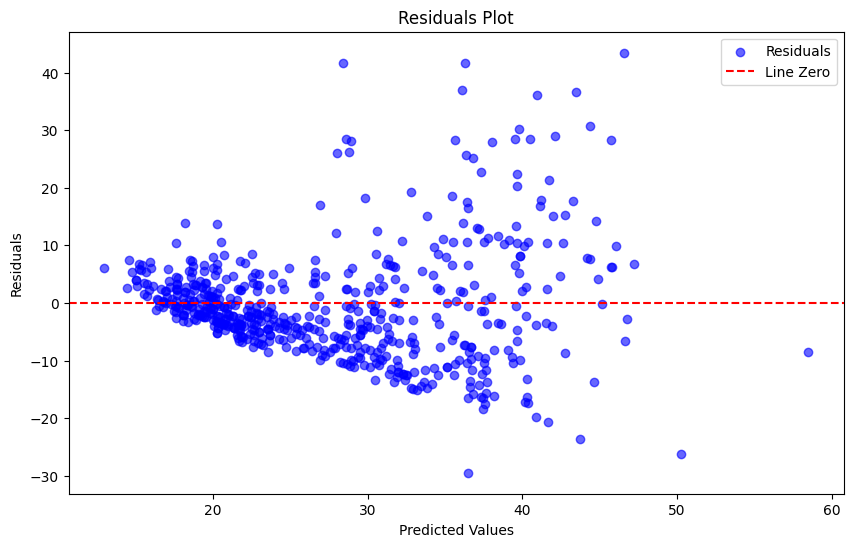

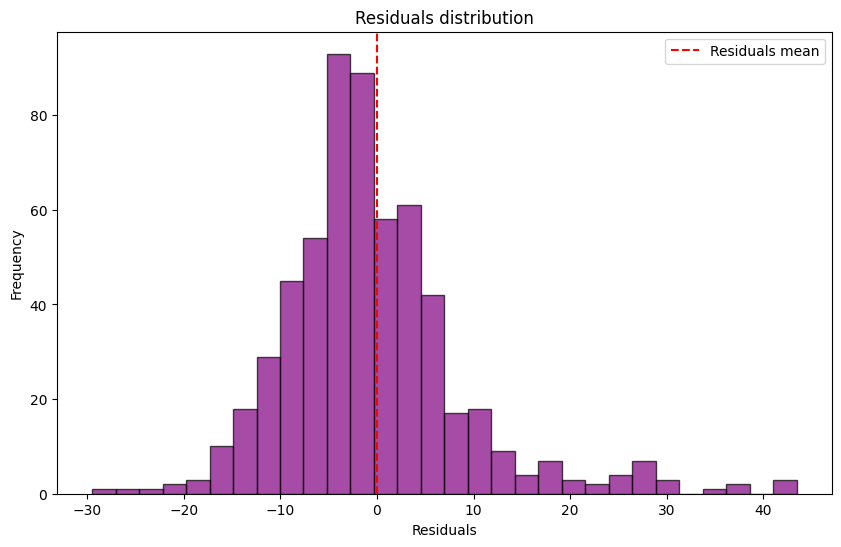

In [18]:
# Visual analysis of the residuals --> the aim is to have residuals distributes as a gaussian N(0, sigma2)
residuals = y_validation - y_pred

# Scatter plot dei residui
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="blue", label="Residuals")
plt.axhline(0, color='red', linestyle='--', label="Line Zero")  # Linea di riferimento a residuo zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.savefig('residuals_RI_1.pdf', format='pdf', bbox_inches='tight') 
plt.show()

# Istogramma dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color="purple", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Residuals mean")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals distribution")
plt.legend()
plt.savefig('residuals_RI_2.pdf', format='pdf', bbox_inches='tight') 
plt.show()

**PREVISION ON THE EVALUATION SET**

In [17]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(copy_dev)
Xdata_dev_scaled = scaler.transform(copy_dev)
Xdata_eval_scaled = scaler.transform(copy_eval.drop(columns=['Id']))

print('Facendo predizione sull\'evaluation set ... ')
model_pred_RI = grid_search_RI.best_estimator_
Xdata_dev_masked = Xdata_dev_scaled[:, mask_RI]
X_data_eval_masked = Xdata_eval_scaled[:, mask_RI]

model_pred_RI.fit(Xdata_dev_masked, ydata_dev)
y_predicted = model_pred_RI.predict(X_data_eval_masked)

# Writing the csv file
with open('results_RI.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id_eval, age_pred in zip(data_eval['Id'], y_predicted):
        writer.writerow([id_eval, age_pred])
    

Facendo predizione sull'evaluation set ... 


#### **MLP REGRESSOR**
For the MLP Regressor is not possible to find the best performing subset of features because RFE needs a way to evaluate the importance each feature has in the regression, metrics that the MLP regressor does not have.

TRAINING THE MLP REGRESSOR ... 

The best score is obtained for numfeat = 10 and its value is 10.200426686313056 


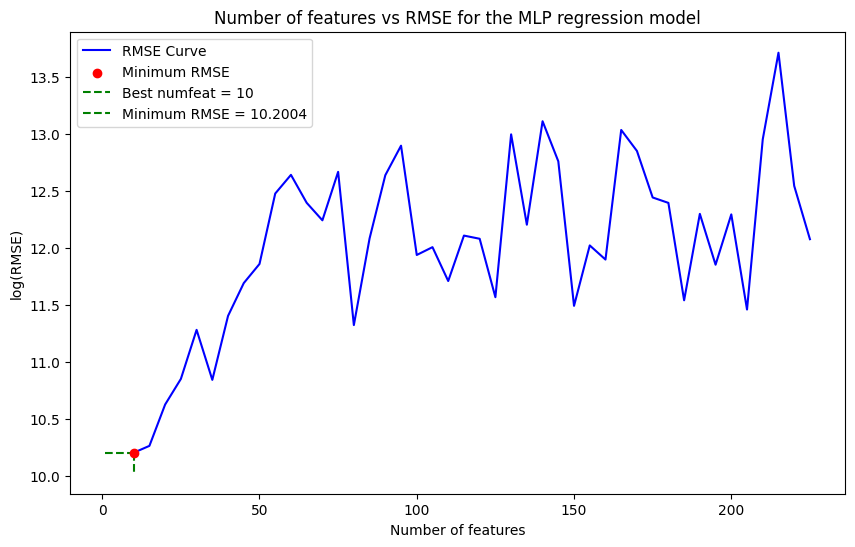

In [28]:
# Defining the best feature
model = MLPRegressor(hidden_layer_sizes=(100,), activation= 'relu', alpha = 0.01, max_iter = 2000)
print('TRAINING THE MLP REGRESSOR ... \n')

best_numfeat = 95
best_score = 50
scores = []

for numfeat in range(10, len(copy_dev.columns), 5):
    kbest = SelectKBest(score_func=f_regression, k = numfeat)
    X_train_selected = kbest.fit_transform(X_train, y_train)
    X_test_selected = kbest.transform(X_validation)

    # Fitting and evaluating the model 
    model.fit(X_train_selected, y_train)
    score = root_mean_squared_error(y_validation, model.predict(X_test_selected))
    scores.append(score)

    if score < best_score:
      best_score = score
      best_numfeat = numfeat
        
print(f'The best score is obtained for numfeat = {best_numfeat} and its value is {best_score} ')


# PLOT NUM_FEAT - RMSE
plt.figure(figsize=(10, 6))
xseq = range(10, len(copy_dev.columns), 5)
plt.plot(xseq, scores, label='RMSE Curve', color='blue')
plt.scatter([best_numfeat], [best_score], color='red', zorder=5, label='Minimum RMSE')
plt.plot([best_numfeat, best_numfeat], [best_score, plt.ylim()[0]], color='green', linestyle='--', label=f'Best numfeat = {best_numfeat}')
plt.plot([1, best_numfeat], [best_score, best_score], color='green', linestyle='--', label=f'Minimum RMSE = {best_score:.4f}')
plt.xlabel('Number of features')
plt.ylabel('log(RMSE)')
plt.title('Number of features vs RMSE for the MLP regression model')
plt.legend()
plt.savefig('rmse_mlp_new.pdf', format='pdf', bbox_inches='tight')  # Puoi cambiare 'svg' in 'pdf' o altri formati vettoriali

plt.show()


In [29]:
# Computing the best mask
kbest = SelectKBest(score_func=f_regression, k = best_numfeat)
X_train_selected = kbest.fit_transform(X_train, y_train)
X_test_selected = kbest.transform(X_validation)

# Hyper-parameters tuning
model_name = 'MLP Regressor'
model_details = {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes' : [(100,), (100,2), (50,), (200,)],
            'activation': ['tanh', 'logistic', 'relu'],
            'alpha': [1, 0.01],
            'max_iter': [1000, 2000]
        }
    }
   
   
grid_search_MLP = GridSearchCV(
    estimator=model_details['model'],
    param_grid=model_details['params'],
    cv=5,  # Numero di fold per la cross-validation
    scoring='neg_mean_squared_error',  # Usare MSE come metrica di valutazione
    n_jobs=-1
)              
                 
                
# Performin the gridsearch
grid_search_MLP.fit(X_train_selected, y_train)

# Storing the results
best_params_MLP =  grid_search_MLP.best_params_,
best_MSE_MLP = -grid_search_MLP.best_score_  # Invertire il segno per MSE

print(f"Migliori parametri per {model_name}: {grid_search_MLP.best_params_}")
print(f"Miglior MSE (cross-val): {best_MSE_MLP:.4f}")
           
                
# Validation
y_pred = grid_search_MLP.best_estimator_.predict(X_test_selected)
rmse_test = root_mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print(f"RMSE sui dati di test: {rmse_test:.4f}")
print(f"R^2 sui dati di test: {r2:.4f}")


Migliori parametri per MLP Regressor: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'max_iter': 2000}
Miglior MSE (cross-val): 119.9758
RMSE sui dati di test: 10.0297
R^2 sui dati di test: 0.3927


c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


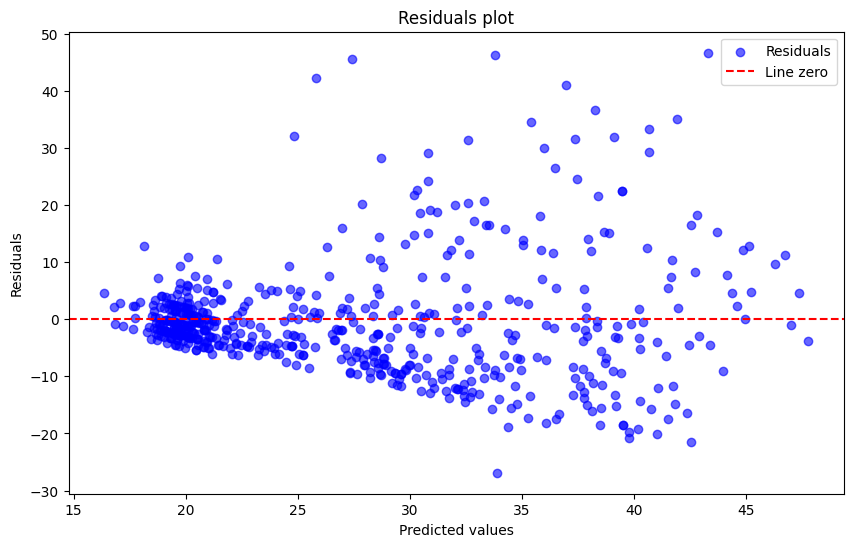

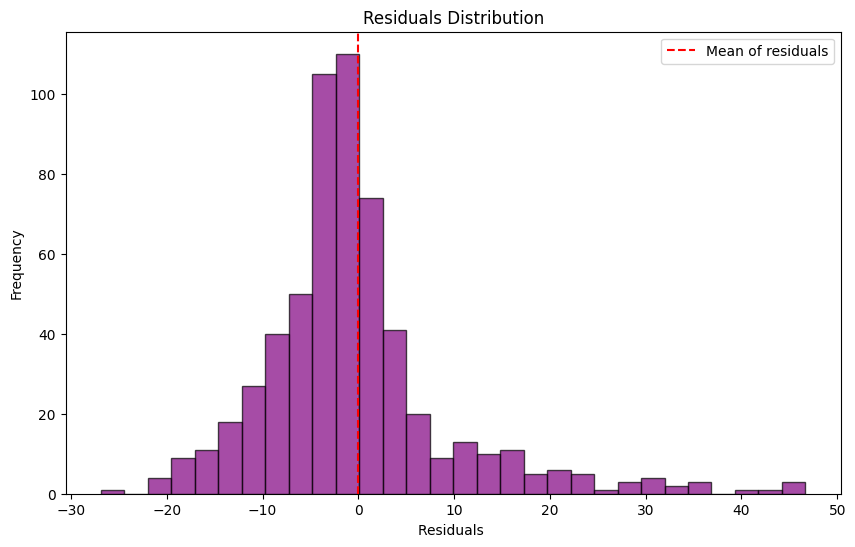

In [30]:
# Visual analysis of the residuals --> the aim is to have residuals distributes as a gaussian N(0, sigma2)
residuals = y_validation - y_pred

# Scatter plot dei residui
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="blue", label="Residuals")
plt.axhline(0, color='red', linestyle='--', label="Line zero")  # Linea di riferimento a residuo zero
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals plot")
plt.legend()
plt.savefig('residuals_mlp_2.pdf', format='pdf', bbox_inches='tight')  # Puoi cambiare 'svg' in 'pdf' o altri formati vettoriali

plt.show()

# Istogramma dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color="purple", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Mean of residuals")
plt.xlabel("Residuals ")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.legend()
plt.savefig('residuals_mlp_1.pdf', format='pdf', bbox_inches='tight')  # Puoi cambiare 'svg' in 'pdf' o altri formati vettoriali

plt.show()

**PREVISION ON THE EVALUATION SET**

In [31]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(copy_dev)
Xdata_dev_scaled = scaler.transform(copy_dev)
Xdata_eval_scaled = scaler.transform(copy_eval.drop(columns=['Id']))

Xdata_dev_masked = kbest.transform(Xdata_dev_scaled)
Xdata_eval_masked = kbest.transform(Xdata_eval_scaled)

print('Facendo predizione sull\'evaluation set ... ')
model_pred_MLP = grid_search_MLP.best_estimator_

model_pred_MLP.fit(Xdata_dev_masked, ydata_dev)
y_predicted = model_pred_MLP.predict(Xdata_eval_masked)

# Writing the csv file
with open('results_MLP.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id_eval, age_pred in zip(data_eval['Id'], y_predicted):
        writer.writerow([id_eval, age_pred])
    

Facendo predizione sull'evaluation set ... 


c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### **RANDOM FOREST REGRESSOR**

In [ ]:
model = RandomForestRegressor(n_estimators=200)
print('TRAINING THE RANDOM FOREST REGRESSOR ... \n')

best_numfeat = 95
best_score = 50
scores = []


# First we define the features which best describe the dataset
for numfeat in range(10, len(copy_dev.columns), 5):
    rfe = RFE(model, n_features_to_select= numfeat)  
    rfe.fit(X_train, y_train)
    
    X_train_selected_forest = rfe.transform(X_train)
    X_test_selected_forest = rfe.transform(X_validation)

    # Fit and evaluating the model
    model.fit(X_train_selected_forest, y_train)
    score = root_mean_squared_error(y_validation, model.predict(X_test_selected_forest))
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_numfeat = numfeat
        
print(f'The best score is obtained for numfeat = {best_numfeat} and its value is {best_score} ')  


# PLOT NUM_FEAT - RMSE
plt.figure(figsize=(10, 6))
xseq = range(10, len(copy_dev.columns), 5)
plt.plot(xseq, scores, label='RMSE Curve', color='blue')
plt.scatter([best_numfeat], [best_score], color='red', zorder=5, label='Minimum RMSE')
plt.plot([best_numfeat, best_numfeat], [best_score, plt.ylim()[0]], color='green', linestyle='--', label=f'Best numfeat = {best_numfeat}')
plt.plot([1, best_numfeat], [best_score, best_score], color='green', linestyle='--', label=f'Minimum RMSE = {best_score:.4f}')
plt.xlabel('Number of features')
plt.ylabel('log(RMSE)')
plt.title('Number of features vs RMSE for the Random Forest Regressor regression model')
plt.legend()
plt.savefig('random_forest.pdf', format='pdf', bbox_inches='tight')  # Puoi cambiare 'svg' in 'pdf' o altri formati vettoriali

plt.show()


TRAINING THE RANDOM FOREST REGRESSOR ... 



In [ ]:
# Computing the best mask
rfe = RFE(model, n_features_to_select= best_numfeat)  
rfe.fit(X_train, y_train)

mask_RF = rfe.support_
features_used_RF = Xdata_dev.columns[mask_RF].to_list()
print(features_used_RF)  # the mask of the selected features

X_train_selected_forest = rfe.transform(X_train)
X_test_selected_forest = rfe.transform(X_validation)

# Now we want to find the best hyperparameters of the model
model_name = 'Random Forest Regressor'
model_details = {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
        }
    }
   
   
grid_search_RF = GridSearchCV(
    estimator=model_details['model'],
    param_grid=model_details['params'],
    cv=5,  # Numero di fold per la cross-validation
    scoring='neg_mean_squared_error',  # Usare MSE come metrica di valutazione
    n_jobs=-1
)              
                 
                
# Performin the gridsearch
grid_search_RF.fit(X_train_selected_forest, y_train)

# Storing the results
best_params_RF =  grid_search_RF.best_params_,
best_MSE_RF = -grid_search_RF.best_score_  # Invertire il segno per MSE

print(f"Migliori parametri per {model_name}: {grid_search_RF.best_params_}")
print(f"Miglior MSE (cross-val): {best_MSE_RF:.4f}")
           
                
# Validation
y_pred = grid_search_RF.best_estimator_.predict(X_validation[:, mask_RF])
rmse_test = root_mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print(f"RMSE sui dati di test: {rmse_test:.4f}")
print(f"R^2 sui dati di test: {r2:.4f}")


In [ ]:
# Visual analysis of the residuals --> the aim is to have residuals distributes as a gaussian N(0, sigma2)
residuals = y_validation - y_pred

# Scatter plot dei residui
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="blue", label="Residuals")
plt.axhline(0, color='red', linestyle='--', label="Line zero")  # Linea di riferimento a residuo zero
plt.xlabel("predicted values")
plt.ylabel("Residuals")
plt.title("Residuals plot")
plt.legend()
plt.show()

# Istogramma dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color="purple", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="mean of residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.legend()
plt.show()

**PREVISION ON THE EVALUATION SET**

In [ ]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(copy_dev)
Xdata_dev_scaled = scaler.transform(copy_dev)
Xdata_eval_scaled = scaler.transform(copy_eval.drop(columns=['Id']))

print('Facendo predizione sull\'evaluation set ... ')
model_pred_RF = grid_search_RF.best_estimator_

model_pred_RF.fit(Xdata_dev_scaled, ydata_dev)
y_predicted = model_pred_RF.predict(Xdata_eval_scaled)

# Writing the csv file
with open('results_RF.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id_eval, age_pred in zip(data_eval['Id'], y_predicted):
        writer.writerow([id_eval, age_pred])
    

## **RISULTATI LEADERBOEARD**

RIDGE --> 9.974
MLP --> 9.868
RANDOM FOREST --> 